In [10]:
!pip install transformers torch plotly
!pip install matplotlib
!pip install nbformat>=4.2.0 plotlyt
!pip install --upgrade plotly nbforma
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
import zlib
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any
from IPython.display import HTML, display
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go


# ---------------------------------------------------------
# 1. CORRECT PLANTUML ENCODER
# ---------------------------------------------------------
def plantuml_encode(text: str) -> str:
    zlibbed = zlib.compress(text.encode("utf-8"))[2:-4]

    def encode6bit(b: int) -> str:
        if b < 10: return chr(48 + b)
        b -= 10
        if b < 26: return chr(65 + b)
        b -= 26
        if b < 26: return chr(97 + b)
        b -= 26
        return "-" if b == 0 else "_" if b == 1 else "?"

    encoded = ""
    for i in range(0, len(zlibbed), 3):
        b1 = zlibbed[i]
        b2 = zlibbed[i + 1] if i + 1 < len(zlibbed) else 0
        b3 = zlibbed[i + 2] if i + 2 < len(zlibbed) else 0

        c1 = b1 >> 2
        c2 = ((b1 & 0x3) << 4) | (b2 >> 4)
        c3 = ((b2 & 0xF) << 2) | (b3 >> 6)
        c4 = b3 & 0x3F

        encoded += (
            encode6bit(c1) +
            encode6bit(c2) +
            encode6bit(c3) +
            encode6bit(c4)
        )

    return encoded


def make_plantuml_url(uml_text: str) -> str:
    """Always build a correct URL."""
    return "https://www.plantuml.com/plantuml/svg/" + plantuml_encode(uml_text)


# ---------------------------------------------------------
# 2. CONFIG
# ---------------------------------------------------------
@dataclass
class BPMNConfig:
    model_name: str = "jtlicardo/bpmn-information-extraction-v2"


config = BPMNConfig()


# ---------------------------------------------------------
# 3. BPMN Extractor
# ---------------------------------------------------------
class BPMNExtractor:
    def __init__(self, cfg: BPMNConfig):
        self.cfg = cfg
        self.tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)
        self.model = AutoModelForTokenClassification.from_pretrained(cfg.model_name)

    # ---------- ENTITY EXTRACTION ----------
    def extract_entities(self, text: str) -> List[Tuple[str, str]]:
        inputs = self.tokenizer(text, return_tensors="pt")
        with torch.no_grad():
            outputs = self.model(**inputs)

        tokens = self.tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
        predictions = torch.argmax(outputs.logits, dim=-1)[0]

        merged: List[Tuple[str, str]] = []
        current_word = ""
        current_label = None

        print("=== TOKENS + LABELS ===")
        for token, pred in zip(tokens, predictions):
            label = self.model.config.id2label[int(pred)]
            print(f"{token:15} -> {label}")

            if token.startswith("##"):
                current_word += token[2:]
                continue

            if current_word:
                merged.append((current_word, current_label))

            current_word = token
            current_label = label

        if current_word:
            merged.append((current_word, current_label))

        print("\n=== MERGED ENTITIES ===")
        for w, l in merged:
            print(f"{w:25} → {l}")

        return merged

    # ---------- STRUCTURE ----------
    def entities_to_structure(self, entities: List[Tuple[str, str]]) -> List[Dict[str, Any]]:
        structure: List[Dict[str, Any]] = []
        cur_word = ""
        cur_type = None

        for word, label in entities:
            low = word.lower()
            if low in ["else", "otherwise"]:
                if cur_word:
                    structure.append({"word": cur_word.strip(), "type": cur_type})
                structure.append({"word": low, "type": "CONDITION"})
                cur_word = ""
                cur_type = None
                continue

            base = label.split("-")[-1] if "-" in label else label

            if base in ["AGENT", "TASK", "CONDITION", "TASK_INFO"]:
                if label.startswith("B-"):
                    if cur_word:
                        structure.append({"word": cur_word.strip(), "type": cur_type})
                    cur_word = word + " "
                    cur_type = base
                elif label.startswith("I-") and cur_type == base:
                    cur_word += word + " "
            else:
                if cur_word:
                    structure.append({"word": cur_word.strip(), "type": cur_type})
                cur_word = ""
                cur_type = None

        if cur_word:
            structure.append({"word": cur_word.strip(), "type": cur_type})

        print("\n=== INTERMEDIATE STRUCTURE ===")
        for s in structure:
            print(s)

        return structure

    # ---------- BPMN GENERATION ----------
    def structure_to_bpmn(self, structure: List[Dict[str, Any]]) -> str:
        bpmn = ["@startuml"]
        current_lane = None
        inside_if = False

        for item in structure:
            word = item["word"]
            t = item["type"]

            if t == "AGENT":
                if word != current_lane:
                    bpmn.append(f"|{word}|")
                    current_lane = word

            elif t == "CONDITION":
                if word.lower() in ["else", "otherwise"]:
                    bpmn.append("else (no)")
                else:
                    bpmn.append(f"if ({word}?) then (yes)")
                    inside_if = True

            elif t == "TASK":
                bpmn.append(f":{word};")

        if inside_if:
            bpmn.append("endif")

        bpmn.append("stop")
        bpmn.append("@enduml")
        return "\n".join(bpmn)

    # ---------- FULL PIPELINE ----------
    def build_bpmn(self, text: str) -> Dict[str, Any]:
        entities = self.extract_entities(text)
        structure = self.entities_to_structure(entities)
        plantuml = self.structure_to_bpmn(structure)
        url = make_plantuml_url(plantuml)
        return {
            "entities": entities,
            "structure": structure,
            "plantuml": plantuml,
            "url": url
        }

    # ---------- ENTITY VISUALIZATION ----------
    def visualize_entities(self, merged_entities: List[Tuple[str, str]]):
        COLOR_MAP = {
            "AGENT": "#7FDBFF",
            "TASK": "#FFDC00",
            "CONDITION": "#FF851B",
            "TASK_INFO": "#2ECC40",
            "O": "#DDDDDD",
        }

        grouped = []
        cur = ""
        cur_label = None

        for word, label in merged_entities:
            base = label.split("-")[-1] if "-" in label else label
            if base in ["AGENT", "TASK", "CONDITION", "TASK_INFO"]:
                if label.startswith("B-"):
                    if cur:
                        grouped.append((cur.strip(), cur_label))
                    cur = word + " "
                    cur_label = base
                elif label.startswith("I-") and cur_label == base:
                    cur += word + " "
            else:
                if cur:
                    grouped.append((cur.strip(), cur_label))
                    cur = ""
                    cur_label = None
                grouped.append((word, "O"))

        if cur:
            grouped.append((cur.strip(), cur_label))

        html = "<div style='font-family:Arial; line-height:2;'>"
        for word, lbl in grouped:
            color = COLOR_MAP.get(lbl, "#ccc")
            html += f"<span style='background:{color}; padding:4px 8px; margin:4px; border-radius:8px'>{word}</span>"
        html += "</div>"

        display(HTML(html))


# ---------------------------------------------------------
# 4. RESOURCE ANALYZER (SINGLE VERSION)
# ---------------------------------------------------------
class ResourceAnalyzer:
    def __init__(self):
        pass

    def compute_resource_transitions(self, structure):
        agents = [x["word"] for x in structure if x["type"] == "AGENT"]
        freq = {}
        for i in range(len(agents) - 1):
            a, b = agents[i], agents[i + 1]
            if a != b:
                freq[(a, b)] = freq.get((a, b), 0) + 1
        return freq

    def build_interaction_matrix(self, structure):
        freq = self.compute_resource_transitions(structure)
        if not freq:
            return [], np.zeros((0, 0))

        agents = sorted({a for pair in freq for a in pair})
        idx = {a: i for i, a in enumerate(agents)}
        M = np.zeros((len(agents), len(agents)))

        for (a1, a2), value in freq.items():
            M[idx[a1]][idx[a2]] = value

        return agents, M

    def visualize_heatmap(self, structure):
        agents, M = self.build_interaction_matrix(structure)
        if len(agents) == 0:
            print("No data")
            return

        plt.figure(figsize=(7, 6))
        plt.imshow(M)
        plt.colorbar()
        plt.xticks(range(len(agents)), agents, rotation=45)
        plt.yticks(range(len(agents)), agents)
        plt.show()

    def visualize_sankey(self, structure):
        freq = self.compute_resource_transitions(structure)
        if not freq:
            print("No data")
            return

        agents = sorted({a for ab in freq for a in ab})
        idx = {a: i for i, a in enumerate(agents)}
        src, tgt, val = [], [], []

        for (a, b), v in freq.items():
            src.append(idx[a]); tgt.append(idx[b]); val.append(v)

        fig = go.Figure(go.Sankey(
            node=dict(label=agents),
            link=dict(source=src, target=tgt, value=val)
        ))
        fig.show()


# ---------------------------------------------------------
# 5. INITIALIZE
# ---------------------------------------------------------
bpmn_extractor = BPMNExtractor(config)
resource_analyzer = ResourceAnalyzer()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ERROR: Could not find a version that satisfies the requirement plotlyt (from versions: none)
ERROR: No matching distribution found for plotlyt


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ERROR: Could not find a version that satisfies the requirement nbforma (from versions: none)
ERROR: No matching distribution found for nbforma


=== TOKENS + LABELS ===
[CLS]           -> O
The             -> B-AGENT
customer        -> I-AGENT
submit          -> B-TASK
##s             -> I-TASK
a               -> I-TASK
re              -> I-TASK
##fu            -> I-TASK
##nd            -> I-TASK
request         -> I-TASK
,               -> O
the             -> B-AGENT
support         -> I-AGENT
agent           -> I-AGENT
reviews         -> B-TASK
the             -> I-TASK
request         -> I-TASK
and             -> O
if              -> B-CONDITION
the             -> I-CONDITION
request         -> I-CONDITION
is              -> I-CONDITION
valid           -> I-CONDITION
,               -> O
the             -> B-AGENT
finance         -> I-AGENT
department      -> I-AGENT
approve         -> B-TASK
##s             -> I-TASK
the             -> I-TASK
re              -> I-TASK
##fu            -> I-TASK
##nd            -> I-TASK
,               -> O
the             -> B-AGENT
system          -> I-AGENT
processes       -> B-TASK
the 


=== PLANTUML BPMN ===
@startuml
|The customer|
:submits a refund request;
|the support agent|
:reviews the request;
if (if the request is valid?) then (yes)
|the finance department|
:approves the refund;
|the system|
:processes the payment;
|the customer|
:receives a confirmation email;
else (no)
|the support agent|
:informs the customer;
endif
stop
@enduml



=== INTERACTION MATRIX + HEATMAP ===
Agents: ['The customer', 'the customer', 'the finance department', 'the support agent', 'the system']
Matrix:
 [[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]]


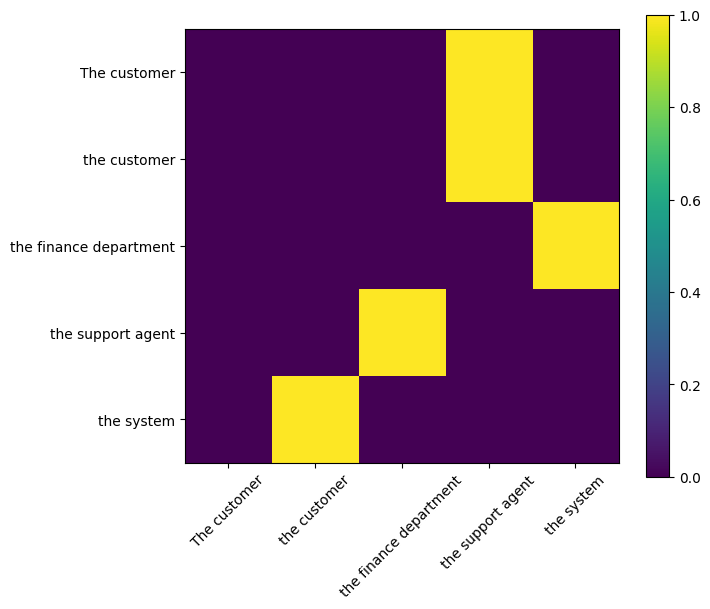


=== SANKEY ===


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [11]:
text = """
The customer submits a refund request, the support agent reviews the request
and if the request is valid, the finance department approves the refund, the system processes the payment, the customer receives a confirmation email
else the support agent informs the customer.
"""

# 1. Строим BPMN
result = bpmn_extractor.build_bpmn(text)
structure = result["structure"]

# 2. Подсветка сущностей
print("\n=== ENTITY HIGHLIGHTING ===")
bpmn_extractor.visualize_entities(result["entities"])

print("\n=== PLANTUML BPMN ===")
print(result["plantuml"])
display(HTML(f'<img src="{result["url"]}">'))
display(HTML(f'<a href="{result["url"]}" target="_blank">{result["url"]}</a>'))

# 3. Матрица + Heatmap
print("\n=== INTERACTION MATRIX + HEATMAP ===")
agents, M = resource_analyzer.build_interaction_matrix(structure)
print("Agents:", agents)
print("Matrix:\n", M)
resource_analyzer.visualize_heatmap(structure)

# 4. Sankey
print("\n=== SANKEY ===")
resource_analyzer.visualize_sankey(structure)
print(result["url"])
